In this article, I'll examine some common techniques used in time series analysis, plotting graphiques, somes tricks... by applying them to a data set containing daily closing values for the CAC40 stock market index. 
  

## Get started by downloading data from yahoo finance


In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web #package and modules for importing data
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
import seaborn as sns 
#sns.set(style = "whitegrid", color_codes = True)
#sns.set(font_scale = 1)

Populating the interactive namespace from numpy and matplotlib


In [2]:
start = datetime.datetime(2016,1,1)
end = datetime.date.today()

#Let's get CAC40 stock data
Cac40 = '^FCHI' #CAC40's ticker symbol is ^FCHI
DataCac = web.DataReader(Cac40, "yahoo", start, end) 
DataCac.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,4582.049805,4586.109863,4490.299805,4522.450195,130633900,4522.450195
2016-01-05,4573.540039,4575.450195,4481.700195,4537.629883,104182900,4537.629883
2016-01-06,4528.120117,4533.240234,4440.770020,4480.470215,104877300,4480.470215
2016-01-07,4346.100098,4424.140137,4323.549805,4403.580078,137701000,4403.580078
2016-01-08,4404.180176,4437.020020,4333.740234,4333.759766,124197200,4333.759766


Let's briefly discuss this. **Open** is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), **High** is the highest price of the stock on that trading day, **Low** the lowest price of the stock on that trading day, and **close** the price of the stock at closing time. **Volume** indicates how many stocks were traded. **Adjusted close** is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.

In [3]:
#Check if there are missing data
#missing data
total = DataCac.isnull().sum().sort_values(ascending=False)
percent = (DataCac.isnull().sum()/DataCac.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Missing data in training test:")
print(missing_data.head())
print("-"*25)

Missing data in training test:
           Total  Percent
Adj Close      0      0.0
Volume         0      0.0
Close          0      0.0
Low            0      0.0
High           0      0.0
-------------------------


It means there is no missing data in this data set. It makes sense because we are dealing with only one index. We are fine until now!  
## Visualizing Data 
  
We want to create two subplots, and both subplots are going to act like they're on a 6x1 grid, where we have 6 rows and 1 column. The first subplot starts at (0,0) on that grid, spans 5 rows, and spans 1 column. The next axis is also on a 6x1 grid, but it starts at (5,0), spans 1 row, and 1 column. The 2nd axis also has the sharex=ax1, which means that ax2 will always align its x axis with whatever ax1's is, and visa-versa

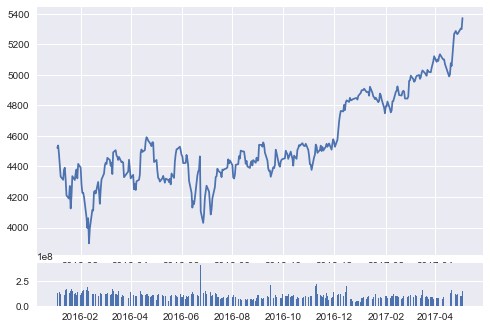

In [4]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan= 5, colspan= 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)

#plt.title('CAC40')
#plt.xlabel('Date')
#plt.ylabel('Adj Close')

ax1.plot(DataCac.index, DataCac['Adj Close'])
ax2.bar(DataCac.index, DataCac['Volume'])
 
plt.show()

**Comments:**  
Take a look on the graphique above, we can see that CAC40 is kind of stable in the first 6 months of 2016. But starting from July 2016, it's trend is increase (from 4200 in July 2016 to 5300 in April 2017). This can be impacted from the Trump administration and his politics, Brexit... I will not focus on details here       
This chart just show us the Adjusted Close Value of CAC40 but there are at least four variables involved for each date(open, high, low, and close) and we would like to have some visual way to see all four variables in the same chart and help us to analyse it.  
A solution for this is **candlestick plot**.  


Populating the interactive namespace from numpy and matplotlib


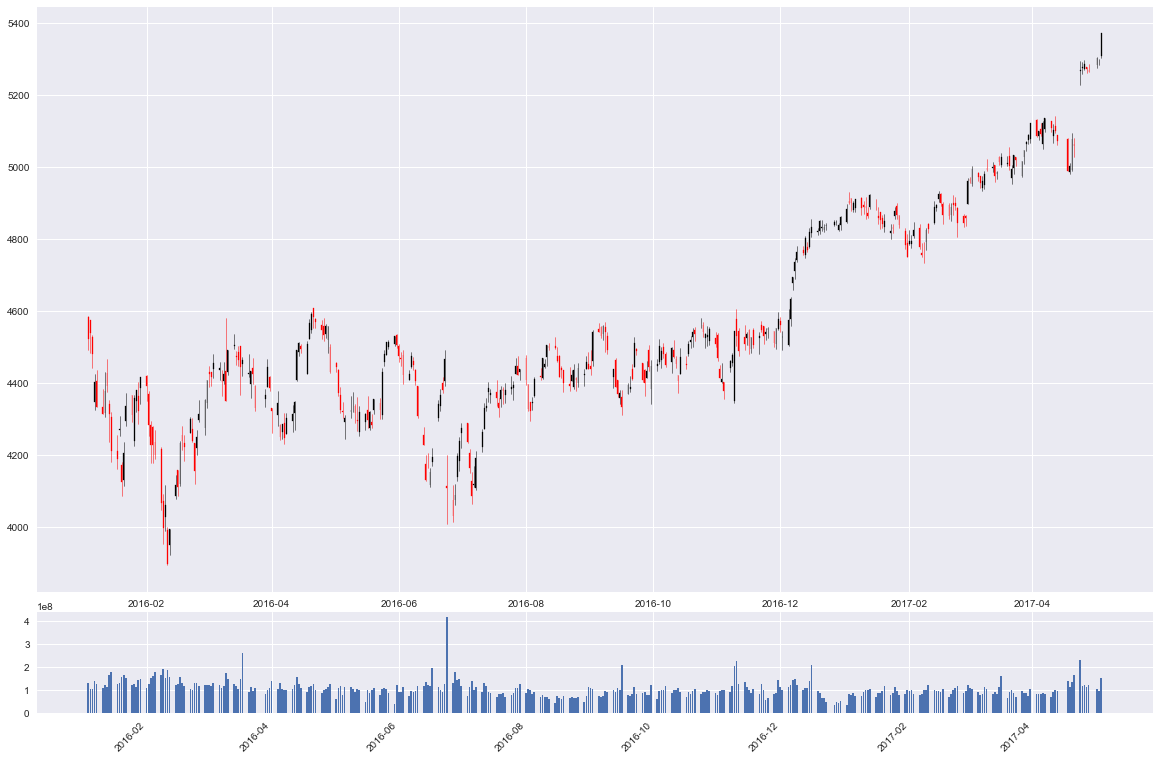

In [5]:
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 13)   # Change the size of plots

def pandas_candlestick_ohlc(data, stick  = "day", otherseries = None):
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    dayFormatter = DateFormatter('%d')  
    
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdata = data.loc[:,["Open","High","Low","Close"]]
    if (type(stick)== str):
        if stick == "day":
            plotdata = transdata
            stick = 1 
        elif stick in ["week","month","year"]:
            if stick == "week":
                transdata["week"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[1])#identify weeks
            elif stick == "month":
                transdata["month"] = pd.to_datetime(transdata.index).map(lambda x: x.month) # Identify months
            else:
                transdata["year"] = pd.to_datetime(transdata.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdata.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdata = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            
            for name, group in grouped:
                plotdata = plotdata.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
    elif (type(stick) == int and stick >= 1):
        transdata["stick"] = [np.floor(i / stick) for i in range(len(transdata.index))]
        grouped = transdata.groupby("stick")
        plotdata = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdata = plotdata.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
            
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
        
    # Set plot parameters, including the axis object ax used for plotting
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan= 5, colspan= 1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
    #fig = plt.subplots()
    #fig.subplots_adjust(bottom=0.2)
    if plotdata.index[-1] - plotdata.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax2.xaxis.set_major_locator(mondays)
        ax2.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax2.xaxis.set_major_formatter(weekFormatter)
    
    ax1.grid(True)
    
    # Create the candelstick chart
    candlestick_ohlc(ax1, list(zip(list(date2num(plotdata.index.tolist())), plotdata["Open"].tolist(), plotdata["High"].tolist(),
                      plotdata["Low"].tolist(), plotdata["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
    
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        data.loc[:,otherseries].plot(ax = ax1, lw = 1.3, grid = True)

    ax1.xaxis_date()
    ax1.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    ax2.bar(data.index, data['Volume'])
    plt.show()

pandas_candlestick_ohlc(DataCac)

With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain) while a red candlestick indicates a day where the open was higher than the close (a loss). See this [wiki source](https://en.wikipedia.org/wiki/Candlestick_chart)   
    
 

# Moving Averages

Let's consider how we can find trends in stocks.  
A *q*-day moving average is, for a series $x_i$ and a point in time t, the average of the past *q* days: that is, if $MA_i^q$ denotes a moving average process, then: 
$$ MA_t^q = \frac{1}{q}\displaystyle\sum_{i=0}^{q-1} x_{t-i}$$  
  
Moving averages smooth a series and helps identify trends by cutting down the amount of "noise". The larger $q$ is, the less responsive a moving average process is to short-term fluctuations in the series $x_t$. Fast moving averages have smaller $q$ and more closely follow the stock, while slow moving averages have larger $q$, resulting in them responding less to the fluctuations of the stock and being more stable.
  
I will create a 20-day (one month) moving average for the CAC40 data and plotting it alongside the stock

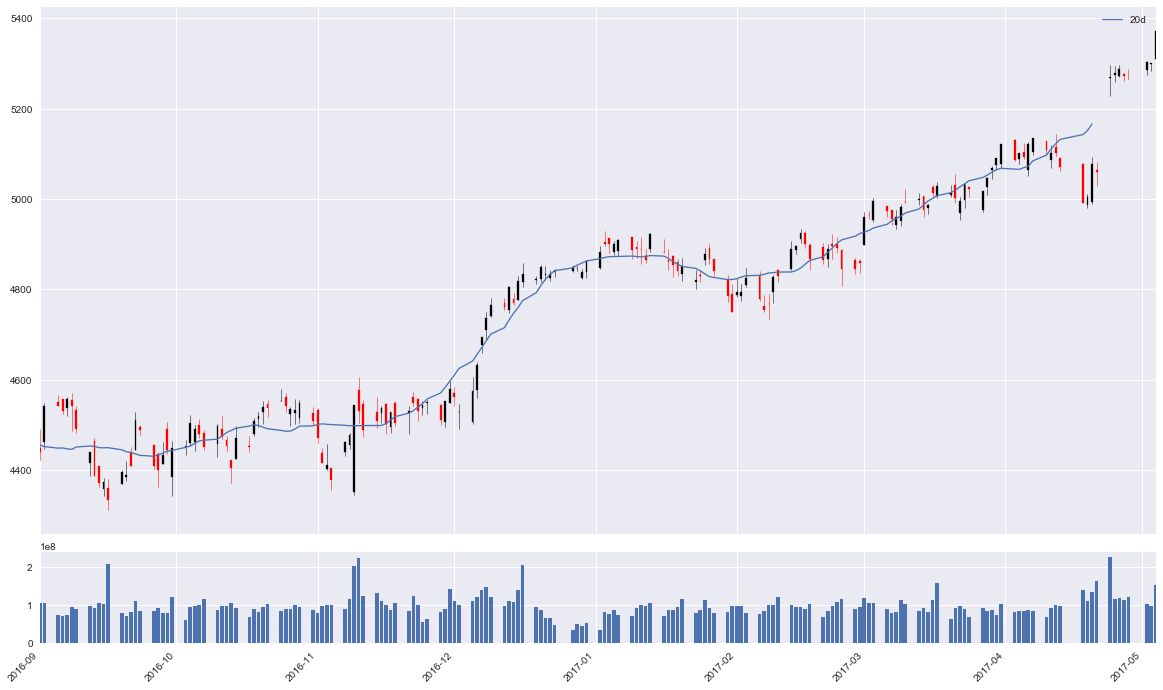

,Open,High,Low,Close,Volume,Adj Close,20d
Date,,,,,,,
2016-01-04,4582.049805,4586.109863,4490.299805,4522.450195,130633900,4522.450195,NaN
2016-01-05,4573.540039,4575.450195,4481.700195,4537.629883,104182900,4537.629883,NaN
2016-01-06,4528.120117,4533.240234,4440.770020,4480.470215,104877300,4480.470215,NaN
2016-01-07,4346.100098,4424.140137,4323.549805,4403.580078,137701000,4403.580078,NaN
2016-01-08,4404.180176,4437.020020,4333.740234,4333.759766,124197200,4333.759766,NaN


In [6]:
DataCac["20d"] = np.round(DataCac["Close"].rolling(window = 20, center = True).mean(), 2)
pandas_candlestick_ohlc(DataCac.loc['2016-09-01':'2017-12-31',:], otherseries = "20d")
DataCac.head()

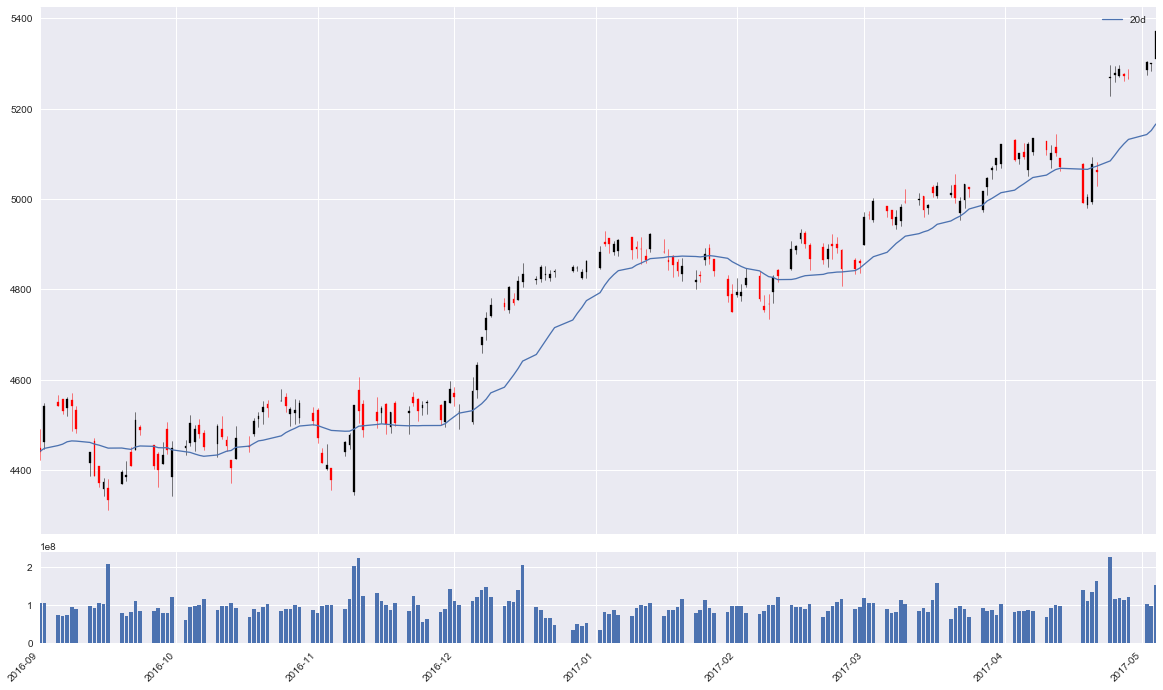

,Open,High,Low,Close,Volume,Adj Close,20d,50d,100d,20d - 50d,Regime,Signal
Date,,,,,,,,,,,,
2016-01-04,4582.049805,4586.109863,4490.299805,4522.450195,130633900,4522.450195,NaN,NaN,NaN,NaN,0.0,NaN
2016-01-05,4573.540039,4575.450195,4481.700195,4537.629883,104182900,4537.629883,NaN,NaN,NaN,NaN,0.0,0.0
2016-01-06,4528.120117,4533.240234,4440.770020,4480.470215,104877300,4480.470215,NaN,NaN,NaN,NaN,0.0,0.0
2016-01-07,4346.100098,4424.140137,4323.549805,4403.580078,137701000,4403.580078,NaN,NaN,NaN,NaN,0.0,0.0
2016-01-08,4404.180176,4437.020020,4333.740234,4333.759766,124197200,4333.759766,NaN,NaN,NaN,NaN,0.0,0.0


In [23]:
DataCac["20d"] = np.round(DataCac["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(DataCac.loc['2016-09-01':'2017-05-04',:], otherseries = "20d")
DataCac.head()

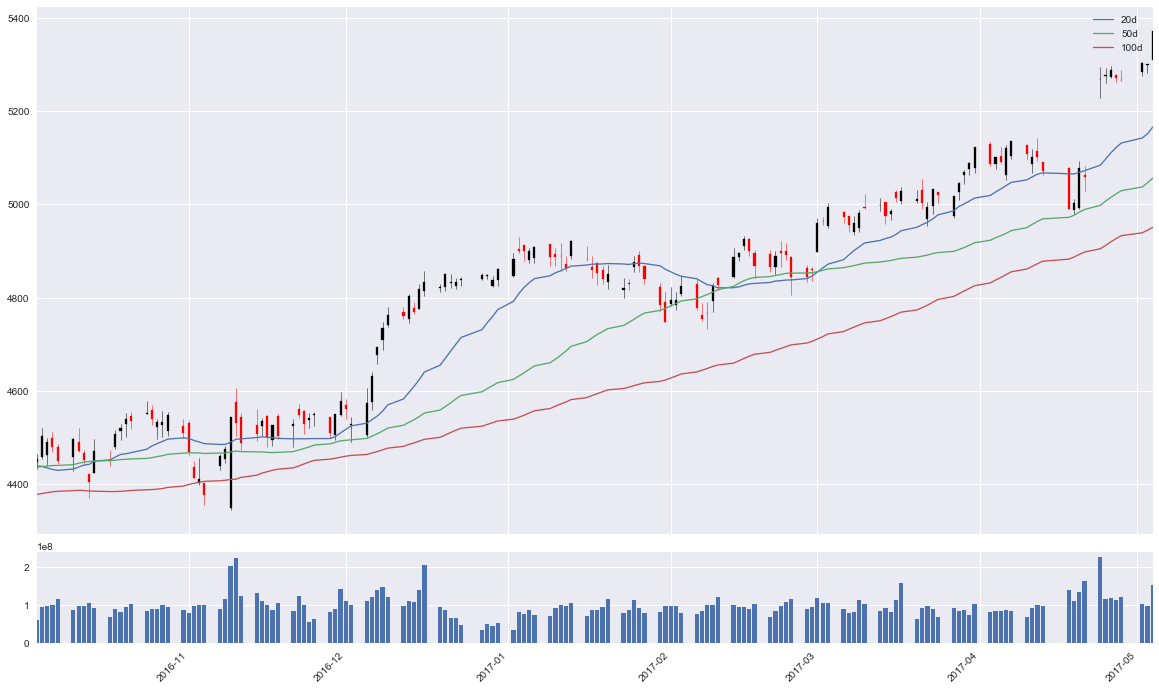

Date
2016-05-24    4346.82
2016-05-25    4346.41
2016-05-26    4346.16
2016-05-27    4346.50
2016-05-30    4347.76
2016-05-31    4349.48
2016-06-01    4351.10
2016-06-02    4351.98
2016-06-03    4352.28
2016-06-06    4353.38
2016-06-07    4356.04
2016-06-08    4358.63
2016-06-09    4359.96
2016-06-10    4361.78
2016-06-13    4361.99
2016-06-14    4359.92
2016-06-15    4358.53
2016-06-16    4356.49
2016-06-17    4354.62
2016-06-20    4354.81
2016-06-21    4354.31
2016-06-22    4354.19
2016-06-23    4356.01
2016-06-24    4354.80
2016-06-27    4352.82
2016-06-28    4351.70
2016-06-29    4352.99
2016-06-30    4355.39
2016-07-01    4357.52
2016-07-04    4360.90
               ...   
2017-03-21    4778.81
2017-03-22    4784.05
2017-03-23    4790.23
2017-03-24    4796.32
2017-03-27    4802.72
2017-03-28    4808.57
2017-03-29    4814.50
2017-03-30    4819.96
2017-03-31    4825.87
2017-04-03    4831.84
2017-04-04    4837.77
2017-04-05    4843.32
2017-04-06    4849.52
2017-04-07    4855.60
2017-

In [22]:
DataCac["50d"] = np.round(DataCac["Close"].rolling(window = 50, center = False).mean(), 2)
DataCac["100d"] = np.round(DataCac["Close"].rolling(window = 100, center = False).mean(), 2)
pandas_candlestick_ohlc(DataCac.loc['2016-10-01':'2017-05-04',:], otherseries = ["20d","50d","100d"])
print(DataCac["100d"][DataCac["100d"] > 0])

The 20-day moving average is the most sensitive to local changes, and the 100-day moving average the least. Here, the 100-day moving average indicates an overall **bearish** trend: the stock is trending downward over time. The 20-day moving average is at times bearish and at other times **bullish**, where a positive swing is expected. You can also see that the crossing of moving average lines indicate changes in trend. These crossings are what we can use as **trading signals**, or indications that a financial security is changing direction and a profitable trade might be made.  
  
"Golden Cross Strategy": A **buy signal** is generated when the short-term average crosses above the long-term average, while a **sell signal** is triggered by a short-term average crossing below a long-term average.
  
"Crossovers": when the price crosses above or below a moving average to signal a potential change in trend.

Moving averages work quite well in strong trending conditions, but often poorly in choppy or ranging conditions.



## Investment Strategy
Any trader must have a set of rules that determine how much of her money she is willing to bet on any single trade. For example, a trader may decide that under no circumstances will she risk more than 10% of her portfolio on a trade. Additionally, in any trade, a trader must have an exit strategy, a set of conditions determining when she will exit the position, for either profit or loss. A trader may set a target, which is the minimum profit that will induce the trader to leave the position. Likewise, a trader may have a maximum loss she is willing to tolerate; if potential losses go beyond this amount, the trader will exit the position in order to prevent any further loss. We will suppose that the amount of money in the portfolio involved in any particular trade is a fixed proportion; 10% seems like a good number.   
Here, I will be demonstrating a moving average crossover strategy.We will use two moving averages, one we consider "fast", and the other "slow". The strategy is:  
1. Trade the asset when the fast moving average crosses over the slow moving average.
2. Exit the trade when the fast moving average crosses over the slow moving average again.
A trade will be prompted when the fast moving average crosses from below to above the slow moving average, and the trade will be exited when the fast moving average crosses below the slow moving average later.   
  
We now have a complete strategy. But before we decide we want to use it, we should try to evaluate the quality of the strategy first. The usual means for doing so is backtesting, which is looking at how profitable the strategy is on historical data. For example, looking at the above chart's performance on CAC40 stock, if the 20-day moving average is the fast moving average and the 50-day moving average the slow, this strategy does not appear to be very profitable, at least not if you are always taking long positions.   
Let's see if we can automate the backtesting task. We first identify when the 20-day average is below the 50-day average, and vice versa.

In [9]:
DataCac["20d - 50d"] = DataCac["20d"] - DataCac["50d"] 
DataCac.tail()

,Open,High,Low,Close,Volume,Adj Close,20d,50d,100d,20d - 50d
Date,,,,,,,,,,
2017-04-27,5276.970215,5278.959961,5261.729980,5271.700195,113942900,5271.700195,5121.79,5022.57,4926.70,99.22
2017-04-28,5267.660156,5287.850098,5265.359863,5267.330078,122645300,5267.330078,5131.70,5029.42,4933.06,102.28
2017-05-02,5284.879883,5305.950195,5274.290039,5304.149902,104617800,5304.149902,5142.43,5037.51,4939.15,104.92
2017-05-03,5299.740234,5301.609863,5282.450195,5301.000000,97848100,5301.000000,5151.35,5046.18,4944.81,105.17
2017-05-04,5309.390137,5372.419922,5304.459961,5372.419922,152534000,5372.419922,5165.68,5056.33,4950.89,109.35


In [10]:
total = DataCac.isnull().sum().sort_values(ascending=False)
percent = (DataCac.isnull().sum()/DataCac.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Missing data in training test:")
print(missing_data.head())
print("-"*25)

Missing data in training test:
           Total   Percent
100d          99  0.288630
20d - 50d     49  0.142857
50d           49  0.142857
20d           19  0.055394
Adj Close      0  0.000000
-------------------------


We will refer to the sign of this difference as the regime; that is, if the fast moving average is above the slow moving average, this is a bullish regime (the bulls rule), and a bearish regime (the bears rule) holds when the fast moving average is below the slow moving average

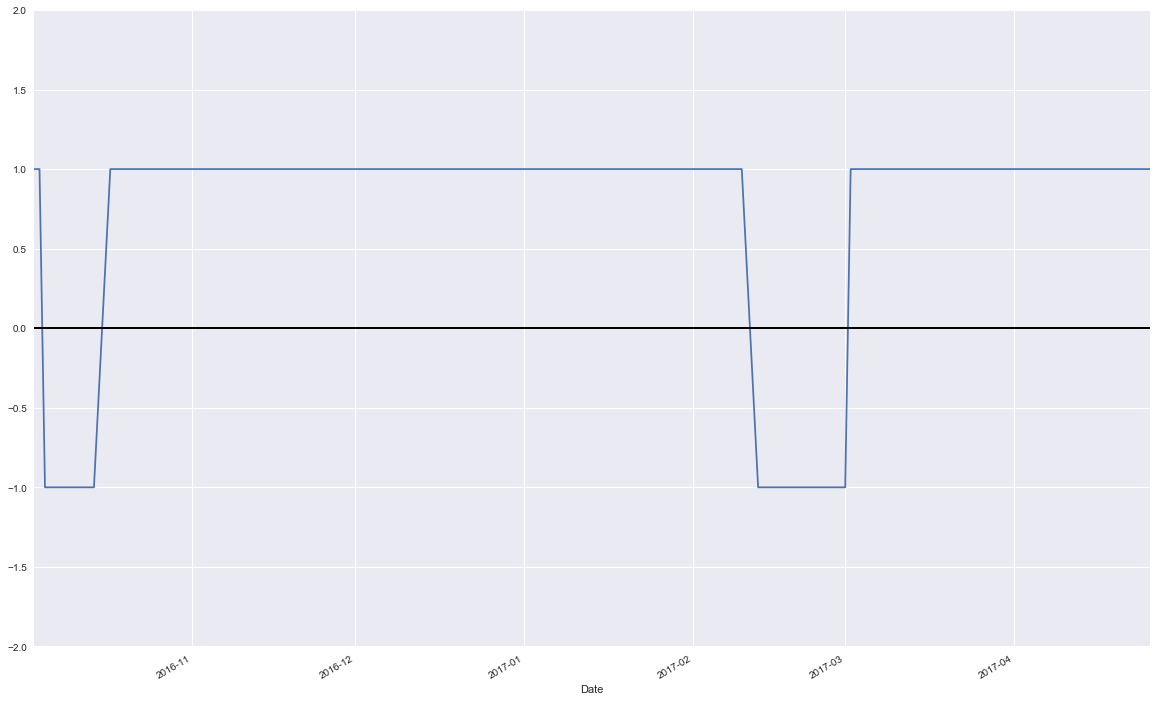

In [11]:
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
DataCac["Regime"] = np.where(DataCac["20d - 50d"] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector
DataCac["Regime"] = np.where(DataCac["20d - 50d"] < 0, -1, DataCac["Regime"])
DataCac.loc['2016-10-01':'2017-04-26',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

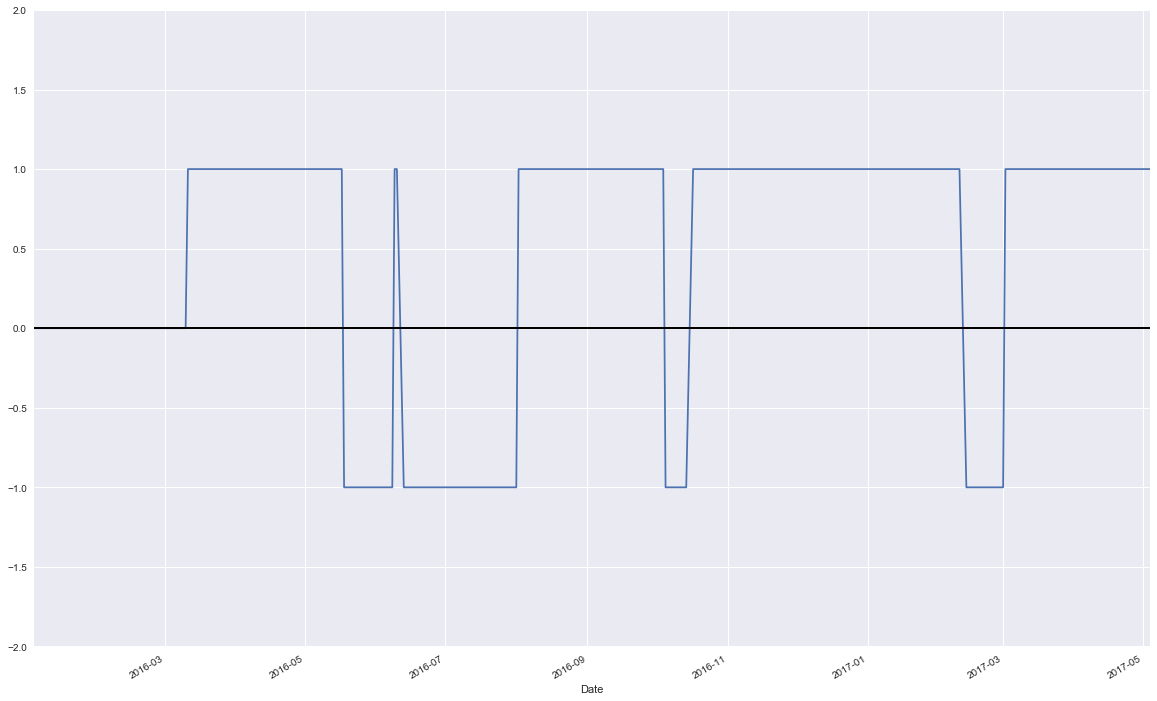

In [12]:
DataCac["Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)

In [13]:
DataCac["Regime"].value_counts()

 1    221
-1     73
 0     49
Name: Regime, dtype: int64

In [14]:
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = DataCac.ix[-1, 'Regime']
DataCac.ix[-1, 'Regime'] = 0
DataCac['Signal'] = np.sign(DataCac['Regime'] - DataCac['Regime'].shift(1))
 #Restore original regime data
DataCac.ix[-1, 'Regime'] = regime_orig
DataCac.tail()

C:\Users\Stagiaire\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in sign


,Open,High,Low,Close,Volume,Adj Close,20d,50d,100d,20d - 50d,Regime,Signal
Date,,,,,,,,,,,,
2017-04-27,5276.970215,5278.959961,5261.729980,5271.700195,113942900,5271.700195,5121.79,5022.57,4926.70,99.22,1.0,0.0
2017-04-28,5267.660156,5287.850098,5265.359863,5267.330078,122645300,5267.330078,5131.70,5029.42,4933.06,102.28,1.0,0.0
2017-05-02,5284.879883,5305.950195,5274.290039,5304.149902,104617800,5304.149902,5142.43,5037.51,4939.15,104.92,1.0,0.0
2017-05-03,5299.740234,5301.609863,5282.450195,5301.000000,97848100,5301.000000,5151.35,5046.18,4944.81,105.17,1.0,0.0
2017-05-04,5309.390137,5372.419922,5304.459961,5372.419922,152534000,5372.419922,5165.68,5056.33,4950.89,109.35,1.0,-1.0


The last line above indicates that for 217 days the market was bearish on CAC40, while for 73 days the market was bullish, and it was neutral for 49 days.  
Trading signals appear at regime changes. When a bullish regime begins, a buy signal is triggered, and when it ends, a sell signal is triggered. Likewise, when a bearish regime begins, a sell signal is triggered, and when the regime ends, a buy signal is triggered  
  
It's simple to obtain signals. Let $r_t$ indicate the regime at time $t$, and $s_t$ the signal at time $t$. Then:
$$\begin{equation*}
s_t = \text{sign}(r_t - r_{t - 1})
\end{equation*}$$
$s_t \in \{-1, 0, 1\}$, with $-1$ indicating "sell", $1$ indicating "buy", and $0$ no action. We can obtain signals like so:

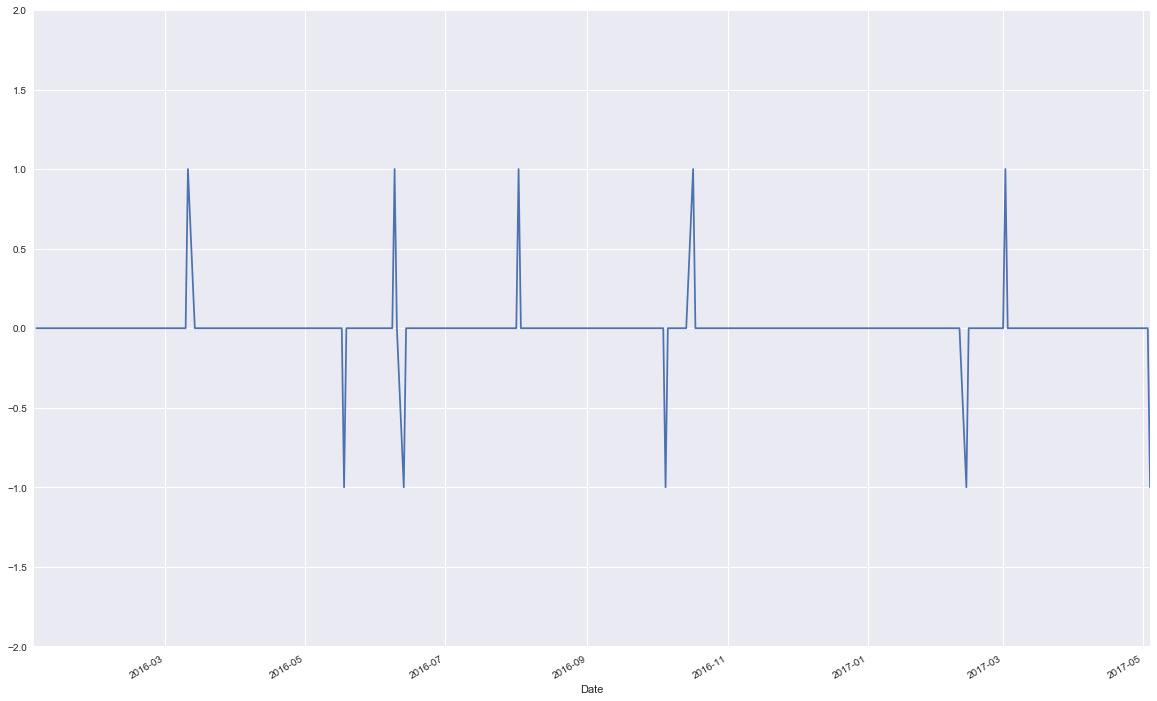

In [15]:
DataCac['Signal'].plot(ylim = (-2, 2))


In [16]:
DataCac["Signal"].value_counts()


 0.0    332
-1.0      5
 1.0      5
Name: Signal, dtype: int64

We would buy CAC40 tracker 5 times and sell CAC40 tracker 5 times.

Let's now try to identify what the prices of the stock is at every buy and every sell.

In [17]:
DataCac.loc[DataCac["Signal"] == 1, "Close"]


Date
2016-03-11    4492.790039
2016-06-09    4405.609863
2016-08-02    4327.990234
2016-10-17    4450.229980
2017-03-02    4963.799805
Name: Close, dtype: float64

In [18]:
DataCac.loc[DataCac["Signal"] == -1, "Close"]

Date
2016-05-18    4319.299805
2016-06-13    4227.020020
2016-10-05    4489.950195
2017-02-13    4888.189941
2017-05-04    5372.419922
Name: Close, dtype: float64

In [19]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
DataCac_signals = pd.concat([
        pd.DataFrame({"Price": DataCac.loc[DataCac["Signal"] == 1, "Close"],
                     "Regime": DataCac.loc[DataCac["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": DataCac.loc[DataCac["Signal"] == -1, "Close"],
                     "Regime": DataCac.loc[DataCac["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
DataCac_signals.sort_index(inplace = True)
DataCac_signals

,Price,Regime,Signal
Date,,,
2016-03-11,4492.790039,1.0,Buy
2016-05-18,4319.299805,-1.0,Sell
2016-06-09,4405.609863,1.0,Buy
2016-06-13,4227.020020,-1.0,Sell
2016-08-02,4327.990234,1.0,Buy
2016-10-05,4489.950195,-1.0,Sell
2016-10-17,4450.229980,1.0,Buy
2017-02-13,4888.189941,-1.0,Sell
2017-03-02,4963.799805,1.0,Buy


In [20]:
# Let's see the profitability of long trades
DataCac_long_profits = pd.DataFrame({
        "Price": DataCac_signals.loc[(DataCac_signals["Signal"] == "Buy") &
                                  DataCac_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(DataCac_signals["Price"] - DataCac_signals["Price"].shift(1)).loc[
            DataCac_signals.loc[(DataCac_signals["Signal"].shift(1) == "Buy") & (DataCac_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": DataCac_signals["Price"].loc[
            DataCac_signals.loc[(DataCac_signals["Signal"].shift(1) == "Buy") & (DataCac_signals["Regime"].shift(1) == 1)].index
        ].index
    })
DataCac_long_profits

,End Date,Price,Profit
Date,,,
2016-03-11,2016-05-18,4492.790039,-173.490234
2016-06-09,2016-06-13,4405.609863,-178.589843
2016-08-02,2016-10-05,4327.990234,161.959961
2016-10-17,2017-02-13,4450.229980,437.959961
2017-03-02,2017-05-04,4963.799805,408.620117


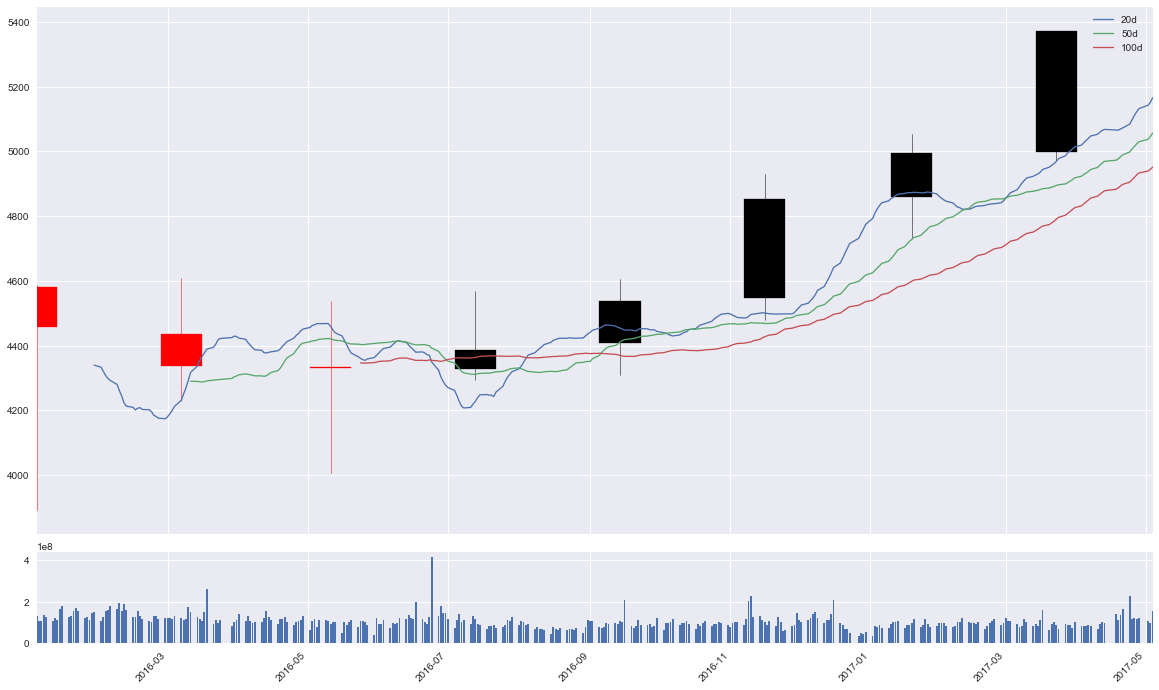

In [21]:
# Let's see the result over the whole period for which we have CAC40 data
pandas_candlestick_ohlc(DataCac, stick = 45, otherseries = ["20d", "50d", "100d"])

## References: 
1. https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
2. https://pythonprogramming.net/stock-data-manipulation-python-programming-for-finance/

